# QAOA for the Max-Cut
First we import the needed libraries

In [3]:
%matplotlib inline
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize, LinearConstraint  

Then we generate graph G(E,V) with n=|V| nodes and m=|E| edges.

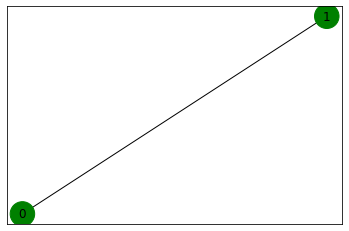

In [4]:
# Generating the butterfly graph with 5 nodes 
n     = 2
V     = np.arange(0,n,1)
E     =[(0,1,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)


Now we define a function that takes the parameters $\gamma$ and $\beta$ and makes a circuit that implements the gates $U^{-i\gamma H}$ and $U^{-i\beta H_{mixing}}$ and measures all the qubits. Then it executes the circuit a number of times given by the parameter shots, and returns the number of counts of every measured n-qubit state. 

In [5]:
def quantum_circuit(G, gamma, beta, backend, shots): #returns an instance of the Results class

    n = len(G.nodes())

    QAOA = QuantumCircuit(n, n)
    QAOA.h(range(n))
    for edge in E:
        k = edge[0]
        l = edge[1]
        QAOA.cu1(-2*gamma, k, l)
        QAOA.u1(gamma, k)
        QAOA.u1(gamma, l)
        
    QAOA.rx(2*beta, range(n))
    QAOA.measure(range(n),range(n))

    job = execute(QAOA, backend=backend, shots=shots)
    #job_monitor(job)
    results = job.result()
    counts = results.get_counts() #dictionary with keys 'bit string x' and items 'counts of x'
    return counts



This function takes a bit string x representing a state and measures the cost

In [6]:

def cost_function_C(x,G):

    E = G.edges()
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])

    return C

Finally, we need to calculate the expectation value of the cost function in the final state, by summing the cost of every measured state in the final state |bra$\gamma$,$\beta$>

In [7]:
def get_expect_value(counts, shots):
    total_cost  = 0
    for state in list(counts.keys()): 
        x = [int(bit_num) for bit_num in list(state)] #the bit string is saved as a list
        cost_x = cost_function_C(x,G)
        total_cost += counts[state]*cost_x
    avr_cost = total_cost/shots
    return avr_cost

# Local simulator
## Solutions grid
We now represent the cost function over the $\gamma,\beta$ space. $\gamma$ is periodic in (0,$\pi$) and $\beta$ is periodic in (0,$2\pi$). 

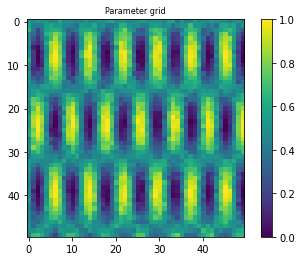

In [8]:

backend = Aer.get_backend("qasm_simulator")
shots = 100

avr_cost_grid = np.zeros((50,50))

for i in np.arange(0, 10, 0.2): #gamma and beta grid
    for j in np.arange(0, 10, 0.2):

        gamma = i
        beta = j

        counts = quantum_circuit(G, gamma, beta, backend, shots)
        avr_cost = get_expect_value(counts, shots)

        avr_cost_grid[int(i*5),int(j*5)] = avr_cost

plt.imshow(avr_cost_grid) #alpha->x axis, beta->y axis #gamma is periodic in (0,pi) and beta in (0,2pi)
plt.title('Parameter grid', fontsize=8)
plt.colorbar()
plt.show()

## Optimizing the expectation value of the cost function
We need a float objective function to minimize that takes gamma and beta and returns the negative of the expectation value of the cost function ( the negative because we want to maximize the expectation value)

In [31]:

def expect_value_function(parameters, backend, G, shots):
    gamma = parameters[0]
    beta = parameters[1]
    counts = quantum_circuit(G,gamma,beta,backend,shots)
    avr_cost = get_expect_value(counts, shots)
    return -avr_cost

Optimal gamma, beta =  0.0 0.750986838414446
Expectation value of the cost function =  0.48


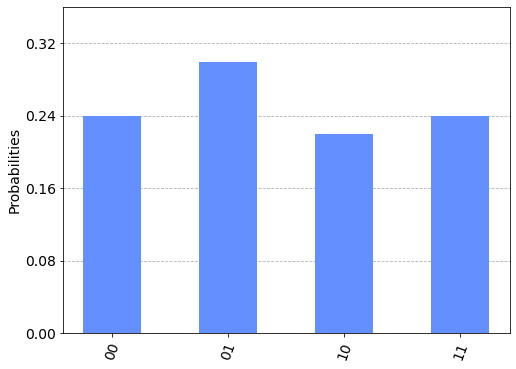

In [40]:
backend = Aer.get_backend("qasm_simulator")
shots = 100

# setting the bounds for gamma and beta
bounds = ((0, np.pi), (0, 2*np.pi)) 

#
max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(backend,G,shots), bounds=bounds, options={'disp': False}, method = 'SLSQP')
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,100)
plot_histogram(counts,figsize = (8,6),bar_labels = False)


# Quantum Inspire

Optimal gamma, beta =  1.0404222005762975 0.0
Expectation value of the cost function =  0.0


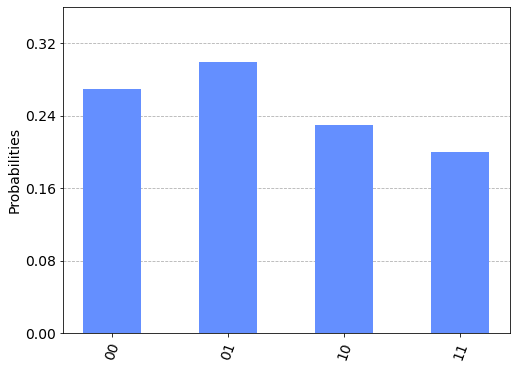

In [39]:
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

save_account('baeb3be4d807b3b6d170dc2d6de5c1b02b1606d1') #saves account with my API token
QI.set_authentication()

qi_backend = QI.get_backend('QX single-node simulator') #quantum inspire simulator
shots = 1

max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(qi_backend,G,shots), bounds=bounds, options={'disp': False}, method = 'SLSQP')
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,100)
plot_histogram(counts,figsize = (8,6),bar_labels = False)
